# ***Fundamentals of Solar Cells***

## **Laboratory Session 05: Extraction of solar cell parameters**

_This notebook contains code to extract the one-diode model parameters of a solar cell from its experimental I-V curve using the 5-point method_ <br>
The algorithm is from: <br>
* Cotfas, D.T., Cotfas, P.A., Kaplanis, S., 2013. Methods to determine the dc parameters of solar cells: A critical review. Renew. Sustain. Energy Rev. 28, 588–596. https://doi.org/10.1016/j.rser.2013.08.017

First we: <br>
· import the Python modules used <br>
· define the Boltzman constant <br>
· define the temperature (we assume it is room temperature) <br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

kB = 8.617333e-5
temperature = 25

#### Function to **generate I-V curves** using as input the parameters of the one-diode model
Used in the second part of this session to analyze the limitations of the 5-point method

In [2]:
def model_IV(IL, I0, n, Rs, Rp, temperature, Inoise, data_size):
    # Thermal voltage
    kBT = kB*(temperature + 273.15)
    
    #I-V curve stored in a 2-column array: first column for voltages, second column for currents
    IVcurve = np.zeros((data_size,2))
    
    # First we calculate the I-V curve voltage range: from -0.1 V to Voc + 0.01 V
    # We want to have the I-V curve crossing the current and voltage axis to see the Isc and Voc
    
    # To calculate the voltage range, we calculate first the Voc without Rs/Rp.
    Voc0 = n*kBT*np.log(IL/I0)
    
    #Create the voltage list
    #Voltage range used: -0.1 to Voc+0.01
    #A "Rs*IL" term is added to compensate for the voltage drop in the Rs
    IVcurve[:,0]= np.linspace(-0.1+Rs*IL, Voc0+0.01, data_size)
    
    #I-V curve without Rs effect
    IVcurve[:,1]= IL - I0*(np.exp(IVcurve[:,0]/(n*kBT))-1) - IVcurve[:,0]/Rp
    
    #Shift voltages to include Rs effect
    IVcurve[:,0] = IVcurve[:,0] - Rs*IVcurve[:,1]
    
    # Add noise to the current.
    # The noise component follows a normal distribution with std dev of I*Inoise
    IVnoise = np.random.default_rng().normal(0, np.absolute(IVcurve[:,1])*Inoise)
    IVcurve[:,1]+=IVnoise
    
   
    return IVcurve

#### Function to extract the I-V curve parameters. 


In [3]:
def get_IV_params(rawIV, temperature, nPntsSlopeIsc, nPntsSlopeVoc):
    # Thermal voltage
    kBT = 8.617333e-5*(temperature + 273.15)
    
    ## 1) Prepare the I-V curve to be in 1st quadrant and 
    ##    with increasing values of voltage
    # Move I-V curve to first quadrant if it is not there yet
    # Sort data and move to first quadrant
    IV_1stq = rawIV.copy()
    Isc = get_Isc(IV_1stq)
    if Isc<0:
        Isc*=-1
        IV_1stq[:,1]*=-1
    
    Voc = get_Voc(IV_1stq)
    if Voc<0:
        Voc*=-1
        IV_1stq[:,0]*=-1    

    # Sort I-V curve data to have increasing values of voltage
    IV_1stq=IV_1stq[IV_1stq[:,0].argsort()]     
    ##
    
    ## 2) Algorithm for the 5-point method
    ##
    
    # Calculate Rp as the inverse of the slope at V=0
    # The function returns the slope and the linear function to be plotted later
    slopeIsc, slopeFitIsc = getSlope_atIsc(IV_1stq, nPntsSlopeIsc)
    Rp = -1/slopeIsc
   
     # Calculate the maximum power and V, I at maximum power point
    Pm, Vm, Im = get_Pmax(rawIV)
    
    # Calculate the slope at Voc as intermediate parameter
    # The function returns the slope and the linear function to be plotted later
    slopeVoc, slopeFitVoc = getSlope_atVoc(IV_1stq, nPntsSlopeVoc)
    
    # Intermediate calculations in the 5-point algorithm
    Rs0 = -1/slopeVoc
    
    A = Vm + Rs0*Im-Voc
    B = np.log(Isc-Vm/Rp-Im)-np.log(Isc-Voc/Rp)
    C = Im/(Isc-Voc/Rp)
    n = A/(kBT*(B+C))    
    
    I0 = (Isc-Voc/Rp)*np.exp(-Voc/(n*kBT))
  
    Rs = Rs0 -n*(kBT/I0)*np.exp(-Voc/(n*kBT))
   
    IL = Isc*(1+Rs/Rp) + I0*(np.exp(Isc*Rs/(n*kBT))-1)


    return IL, I0, n, Rs, Rp, slopeFitIsc, slopeFitVoc

And ancillary functions

In [4]:
# Load I-V file
# Assumes 7 header lines, as in I-V curve files obtained in our lab
def load_IV(IVpath):
    
    rawIV = np.loadtxt(IVpath, skiprows=7)
    
    return rawIV

In [5]:
# Obtains Isc by linear interpolation around V=0
def get_Isc(IVdata):
    """Returns the Isc of the input raw I-V curve"""

   # Sort data
    IV_sorted = IVdata.copy()
    IV_sorted=IVdata[IVdata[:,0].argsort()]   # Sort by voltages
    
    Isc = np.interp(0,IV_sorted[:,0],IV_sorted[:,1])
    
    return Isc

# Obtains Voc by linear interpolation around I=0
def get_Voc(IVdata):
    """Returns the Voc of the input raw I-V curve"""

   # Sort data
    IV_sorted = IVdata.copy()
    IV_sorted=IVdata[IVdata[:,1].argsort()]   # Sort by currents
    
    Voc = np.interp(0, IV_sorted[:,1],IV_sorted[:,0])
    
    return Voc

# Obtains the Pmax, and also the Vm and Im
# No interpolation used.
def get_Pmax(IVdata):

   # Sort data and move to 1st quadrant
    IV_sorted = IVdata.copy()
 
    Isc = get_Isc(IV_sorted)
    if Isc<0:
        Isc*=-1
        IV_sorted[:,1]*=-1
    
    Voc = get_Voc(IV_sorted)
    if Voc<0:
        Voc*=-1
        IV_sorted[:,0]*=-1       
 
    IV_sorted=IV_sorted[IV_sorted[:,0].argsort()]   
   
 
    PV = IV_sorted.copy()
    PV[:,1] = IV_sorted[:,0]*IV_sorted[:,1]
    
    Pm = np.amax(PV[:,1])
    maxPosition = np.argmax(PV[:,1])
 
   
    Vm = PV[maxPosition,0]
    Pm = PV[maxPosition,1]
    Im = Pm/Vm
 
    return Pm, Vm, Im

# Determines the slope of the I-V curve around Voc
# I-V curve is assumed to be in 1st quadrant
def getSlope_atVoc(data, nPnts):
   
    indexLow = 0
    indexHigh = 0
 
    # Find the first negative current point
    # Determine the range for the fit according to nPnts
    rI = np.where(data[:,1] <= 0)
    rangeI = np.asarray(rI)  
    rangeI = rangeI.flatten()   
    
    indexHigh = rangeI[0] + nPnts[1]
    if indexHigh > len(data[:,0])-1:
        indexHigh = len(data[:,0])-1
    indexLow = rangeI[0] - nPnts[0]
    if indexLow < 0:
        indexLow=0
    
    polyCoeffs = np.polyfit(data[indexLow:indexHigh+1,0],data[indexLow:indexHigh+1,1],1)

    slope = polyCoeffs[0]
   
    slopeFitVoc = np.zeros((50,2))
    slopeFitVoc[:,0]=np.linspace(data[indexLow,0],data[indexHigh,0],50)
    slopeFitVoc[:,1] = np.polyval(polyCoeffs, slopeFitVoc[:,0])

    return slope, slopeFitVoc

# Returns the slope of I-V curve at Isc using
# a linear fit for a V range of +-Vrange     
def getSlope_atIsc(data, nPnts):
    # Get data indexes in the Vrange
    rV = np.where(data[:,0] <= 0)
    rangeV = np.asarray(rV)  
    rangeV = rangeV.flatten()   

    indexLow = rangeV[-1] -nPnts[0]   
    if indexLow < 0:
        indexLow=0
    indexHigh = rangeV[-1] + nPnts[1]
    if indexHigh > len(data[:,0])-1:
        indexHigh = len(data[:,0])-1
 
    #Do a linear fit to the range of data
    polyCoeffs = np.polyfit(data[indexLow:indexHigh+1,0],data[indexLow:indexHigh+1,1],1)
    #Take the slope from the linear fit
    slope = polyCoeffs[0]
 
    slopeFitIsc = np.zeros((50,2))
    slopeFitIsc[:,0]=np.linspace(data[indexLow,0],data[indexHigh,0],50)
    slopeFitIsc[:,1] = np.polyval(polyCoeffs, slopeFitIsc[:,0])


    return slope, slopeFitIsc


Now we load an I-V curve and extract its parameters

IL = 0.051
Rp = 1242.918
Rs = 0.024
I0 = 1.14e-09
n = 1.337
Error Isc = -0.000 %
Error Voc = -0.031 %
Error Pmax = -0.023 %
Error FF = 0.006 %


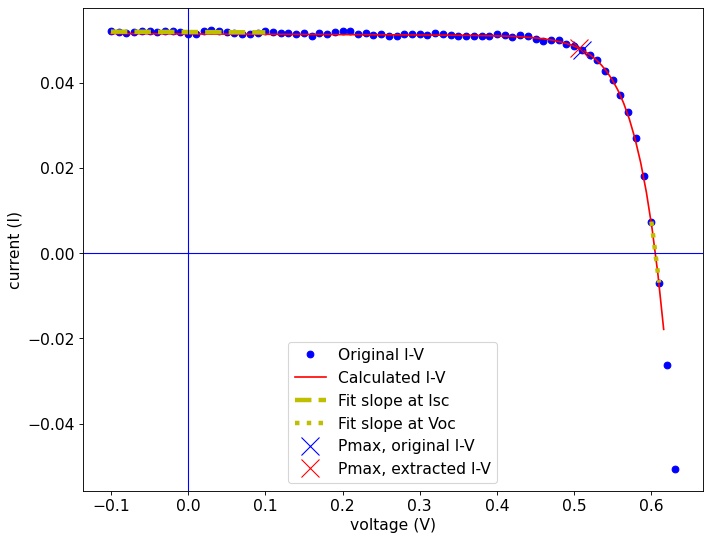

In [16]:
# Load the experimental I-V data
#IVpath = "D:\\ownCloud\\10_DOCENCIA\\2022-23\\FCS\\P5_I-V_fit\\Datos_practica\\Experimental_IV.txt"
IVpath = "Experimental_IV.txt"
IV_curve = load_IV(IVpath)

## Now extract the one-diode model parameters from this I-V curve
# Define the number of points to calculate the slopes of the I-V curve around Isc and Voc
nPntsSlopeIsc = [10,10]
nPntsSlopeVoc = [1,0]

IL_extr, I0_extr, n_extr, Rs_extr, Rp_extr, slopeFitIsc, slopeFitVoc = get_IV_params(
                                                        IV_curve, temperature, nPntsSlopeIsc, nPntsSlopeVoc)

# Create an I-V curve with these extracted parameters, to compare with the original I-V curve
IV_curve_extracted = model_IV(IL_extr, I0_extr, n_extr, Rs_extr, Rp_extr, temperature, 0, 500)

# Get figures of merit of both curves
Isc_extr = get_Isc(IV_curve_extracted)
Voc_extr = get_Voc(IV_curve_extracted)
Pmax_extr, Vmax_extr, Imax_extr= get_Pmax(IV_curve_extracted)
FF_extr = Pmax_extr/(Voc_extr*IL_extr)

Isc = get_Isc(IV_curve)
Voc = get_Voc(IV_curve)
Pmax, Vmax, Imax = get_Pmax(IV_curve)
FF = Pmax/(Voc*Isc)

# Print the results and errors
print("IL = " + f"{IL_extr:.3f}")
print("Rp = " + f"{Rp_extr:.3f}")
print("Rs = " + f"{Rs_extr:.3f}")
print("I0 = " + f"{I0_extr:.3}") 
print("n = " + f"{n_extr:.3f}")

print("Error Isc = " + f"{100*(Isc_extr-Isc)/Isc:.3f}" + " %")
print("Error Voc = " + f"{100*(Voc_extr-Voc)/Voc:.3f}" + " %")
print("Error Pmax = " + f"{100*(Pmax_extr-Pmax)/Pmax:.3f}" + " %")
print("Error FF = " + f"{100*(FF_extr-FF)/FF:.3f}" + " %")

# Plot the I-V curves
plt.figure(figsize=(10, 8),dpi=80)
plt.plot(IV_curve[:,0], IV_curve[:,1], 'bo', label="Original I-V")
plt.plot(IV_curve_extracted[:,0], IV_curve_extracted[:,1], color='r', label = "Calculated I-V")
plt.plot(slopeFitIsc[:,0],slopeFitIsc[:,1], '--', linewidth=4, color='y', label = "Fit slope at Isc")
plt.plot(slopeFitVoc[:,0],slopeFitVoc[:,1], ':', linewidth=4, color='y', label = "Fit slope at Voc")
plt.plot(Vmax, Imax, 'x', markersize=16, color='b', label = "Pmax, original I-V")
plt.plot(Vmax_extr, Imax_extr, 'x', markersize=16, color='r', label = "Pmax, extracted I-V")
#plt.ylim((-0.01, Isc*1.1))
plt. axvline(x=0,linewidth=1, color='b')
plt. axhline(y=0,linewidth=1, color='b')
plt.xlabel('voltage (V)', size=14)
plt.ylabel('current (I)', size=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Work with modelled I-Vs
The following code can be used to model I-V curves and test how the parameter extraction with the 5-point method works 

IL = 0.051
Rp = 2469.372
Rs = 0.034
I0 = 8.6e-10
n = 1.336


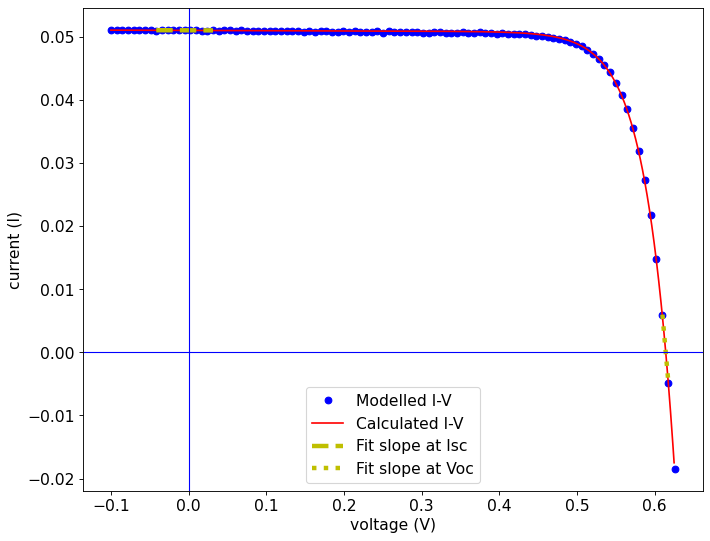

In [40]:
# Create an I-V curve and store it in "modelled_IV" array
IL = 0.051
I0 = 5.15e-10
n = 1.3
Rs = 0.04
Rp = 1000
Inoise = 0.001
nPnts = 100

modelled_IV= model_IV(IL, I0, n, Rs, Rp, temperature, Inoise, nPnts)

## Now extract the one-diode model parameters from this I-V curve
# Define the number of points to calculate the slopes of the I-V curve around Isc and Voc
nPntsSlopeIsc = [5,5]
nPntsSlopeVoc = [1,0]

# Extract the I-V parameters
IL_extr, I0_extr, n_extr, Rs_extr, Rp_extr, slopeFitIsc, slopeFitVoc= get_IV_params(
                                                        modelled_IV, temperature, nPntsSlopeIsc, nPntsSlopeVoc)
# Print the results and errors
print("IL = " + f"{IL_extr:.3f}")
print("Rp = " + f"{Rp_extr:.3f}")
print("Rs = " + f"{Rs_extr:.3f}")
print("I0 = " + f"{I0_extr:.3}") 
print("n = " + f"{n_extr:.3f}")

# Create an I-V curve with these extracted parameters, to compare with the original I-V curve
IV_curve_extracted = model_IV(IL_extr, I0_extr, n_extr, Rs_extr, Rp_extr, temperature, 0, 500)


# Plot the I-V curves
plt.figure(figsize=(10, 8),dpi=80)
plt.plot(modelled_IV[:,0], modelled_IV[:,1], 'bo', label="Modelled I-V")
plt.plot(IV_curve_extracted[:,0], IV_curve_extracted[:,1], color='r', label = "Calculated I-V")
plt.plot(slopeFitIsc[:,0],slopeFitIsc[:,1], '--', linewidth=4, color='y', label = "Fit slope at Isc")
plt.plot(slopeFitVoc[:,0],slopeFitVoc[:,1], ':', linewidth=4, color='y', label = "Fit slope at Voc")
#plt.ylim((-0.01, Isc*1.1))
plt. axvline(x=0,linewidth=1, color='b')
plt. axhline(y=0,linewidth=1, color='b')
plt.xlabel('voltage (V)', size=14)
plt.ylabel('current (I)', size=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()